In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

# A comment

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings

import numpy as np

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
plt.rc('text', usetex=False)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    hstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord as sc
from astropy.utils.console import ProgressBar
from astropy import visualization as vs

import statistics as stat


plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
table_hsc = Table.read('hsc_s16a_fastlane_g09_short.fits', format = 'fits')
table_decals = Table.read ('decals_dr3_g09_short.fits', format = 'fits')

table_hsc.sort('rcmodel_mag')
table_decals.sort('rmag_decal')

ra_hsc = table_hsc['ra']
dec_hsc = table_hsc['dec']
ra_decals = table_decals['RA']
dec_decals = table_decals['DEC']


In [3]:
hsc = sc(ra=ra_hsc*u.degree, dec=dec_hsc*u.degree)  
decals = sc(ra=ra_decals*u.degree, dec=dec_decals*u.degree)  
idx, d2d, d3d = hsc.match_to_catalog_sky(decals)

Now idx are indices into decals catalog that are the closest objects to each of the coordinates in hsc catalog, d2d are the on-sky distances between them, and d3d are the 3-dimensional distances. 

now we get arrays of the luminosities and plot them

In [4]:
#d2d  cut
idx_use = np.asarray(d2d.to(u.arcsec))<=3.0

In [5]:
#merge catalogs and apply d2d cut
table_merge = hstack([table_hsc, table_decals[idx]])
table_use = table_merge[idx_use]

In [6]:
#split into four redshift bins
hsc_z = table_use['z_best']
#.25-.325, .325-.4, .4-.475, .475-.55
idx_1 = (hsc_z < .325)
idx_2 = (hsc_z > .325) & (hsc_z<.4)
idx_3 = (hsc_z > .4) & (hsc_z<.475)
idx_4 = (hsc_z > .475)

In [7]:
r_hsc = table_use['rcmodel_mag'] - table_use['a_r']
r_decal = table_use['rmag_decal'] - table_use['a_r_decal']
r_diff = r_hsc - r_decal
mass = table_use['logm_100']

In [43]:
#copy for altering
xx = r_hsc
yy = r_diff
cc = mass
zz = hsc_z

idx_finite = ((np.isfinite(xx)) & np.isfinite(yy) & np.isfinite(cc) & np.isfinite(zz))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
cc_use = cc[idx_finite]
zz_use = zz[idx_finite]

idx_1 = (zz_use < .325)
idx_2 = ((zz_use > .325) & (zz_use < .400))
idx_3 = ((zz_use > .400) & (zz_use < .475))
idx_4 = (zz_use > 0.475)


565


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2105 but corresponding boolean dimension is 565

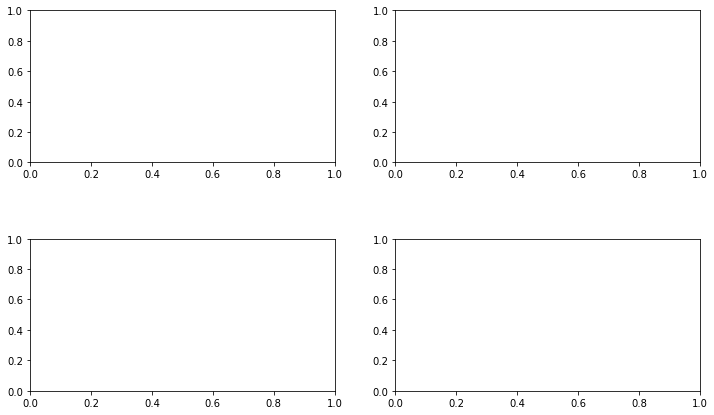

In [48]:
fig, axarr = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.5)

N = 2000
total_bins = 10

bins = np.linspace(xx_use[idx_1].min(),xx_use[idx_1].max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(xx_use[idx_1],bins)
print(len(yy_use[idx]))
running_median = [np.median(yy_use[idx==k]) for k in range(total_bins)]

axarr[0,0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=cc_use[idx_1],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,0].set_title(r'$0.250 < z < 0.325$', 
                     fontsize=20)
axarr[0,0].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)

axarr[1,0].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=cc_use[idx_2],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,0].set_title(r'$0.325 < z < 0.400$', 
                     fontsize=20)
#axarr[1,0].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)

axarr[0,1].scatter(xx_use[idx_3], yy_use[idx_3],
                   c=cc_use[idx_3],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,1].set_title(r'$0.400 < z < 0.475$', 
                     fontsize=20)
#axarr[0,1].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)

sc = axarr[1,1].scatter(xx_use[idx_4], yy_use[idx_4],
                   c=cc_use[idx_4],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,1].set_title(r'$0.475 < z < 0.550$', 
                     fontsize=20)
#axarr[1,1].plot(bins-delta/2,running_median,'--',c='green',linewidth=2.0,lw=4,alpha=.8)

#plt.scatter(xx_use,yy_use,color='k',alpha=.2,s=2)


for (m,n), subplot in np.ndenumerate(axarr):
    subplot.set_xlim(17.6, 21.4)
    subplot.set_ylim(-2.5, 2.5)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=21)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=20)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    
plt.suptitle('R Band Distributions')

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmaps.magma, ticks=[1,0])
type(cbar_ax)

In [11]:
eighty_five = np.percentile(hsc_g_mag, 85)
sixteen = np.percentile(hsc_g_mag, 16)
fifty = np.percentile(hsc_g_mag, 50)

gmag_diff = hsc_g_mag - decals_g_mag

NameError: name 'hsc_g_mag' is not defined

In [ ]:
plt.scatter(hsc_g_mag, gmag_diff,label='_nolegend_')
plt.plot( [eighty_four, eighty_four],[-5, 5], color = 'red', label = '85th percentile')
plt.plot([fifty, fifty], [-5, 5], color = 'purple', label = '50th percentile')
plt.plot( [sixteen,sixteen], [-5, 5], color = 'darkblue', label = '16th percentile')
plt.ylabel("magnitude difference (HSC mag - DECaLS mag)")
plt.xlabel("HSC magnitude")
plt.title("G Band Magnitudes")
plt.legend(loc='upper left')

In [ ]:
eighty_five = np.percentile(hsc_z_mag, 85)
sixteen = np.percentile(hsc_z_mag, 16)
fifty = np.percentile(hsc_z_mag, 50)

zmag_diff = hsc_z_mag - decals_z_mag

In [ ]:
plt.scatter(hsc_z_mag, decals_z_mag-hsc_z_mag,label='_nolegend_' )
plt.plot( [eighty_four, eighty_four],[-5, 5], color = 'red', label = '85th percentile')
plt.plot([fifty, fifty], [-5, 5], color = 'purple', label = '50th percentile')
plt.plot( [sixteen,sixteen], [-5, 5], color = 'darkblue', label = '16th percentile')
plt.ylabel("magnitude difference (HSC mag - DECaLS mag)")
plt.xlabel("HSC magnitude")
plt.title("Z Band Magnitudes")
plt.legend(loc = 'upper left')